# Análisis de series temporales con Facebook Prophet

Fuente del codigo: https://futurice.com/blog/

En este ejemplo utilizaremos los datos de viajeros en bicicleta en un tramo específico en Oslo, Noruega, en Ullevål. Estos datos se combinan con datos meteorologicos del Instituto Meteorológico de Noruega 

In [46]:
#conda install -c conda-forge fbprophet

### Importación de datos

In [47]:
import pandas as pd
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn import preprocessing
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.set_option('display.max_row', 1000)

In [48]:
# Read the data
bikerides = pd.read_csv('dataset/bikerides_day.csv', encoding= 'unicode_escape', delimiter=',')

### Transformar la fecha a formato datetime

In [49]:
# Convert Date to datetime
bikerides['Date'] = pd.to_datetime(bikerides['Date'])
bikerides.head(5)

Date  Volume  Rain  Temp
0 2016-11-17   933.0   9.0   2.1
1 2016-11-18  1197.0   6.7   3.9
2 2016-11-19   243.0   5.4   2.0
3 2016-11-20   234.0   3.9   2.8
4 2016-11-21  2148.0   7.3   2.8

In [50]:
# Rename the columns to Prophet scheme who expect date column to be named "ds" and data column to called "y"
bikerides.columns = ['ds', 'y', 'rain', 'temp']
bikerides.head(1)

ds      y  rain  temp
0 2016-11-17  933.0   9.0   2.1

### Previsualización de datos

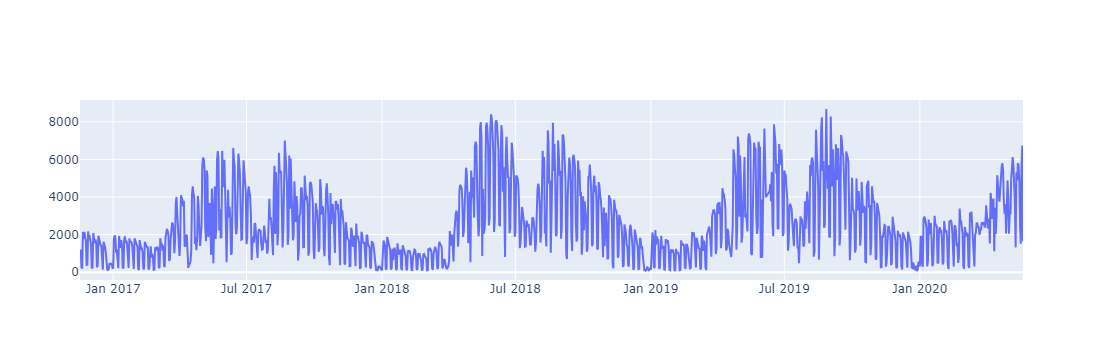

In [51]:
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

### Reducción de variabilidad: eliminación de los fines de semana

In [52]:
# Removing weekends
bikerides.set_index('ds', inplace=True)
bikerides = bikerides[bikerides.index.dayofweek < 5].reset_index()

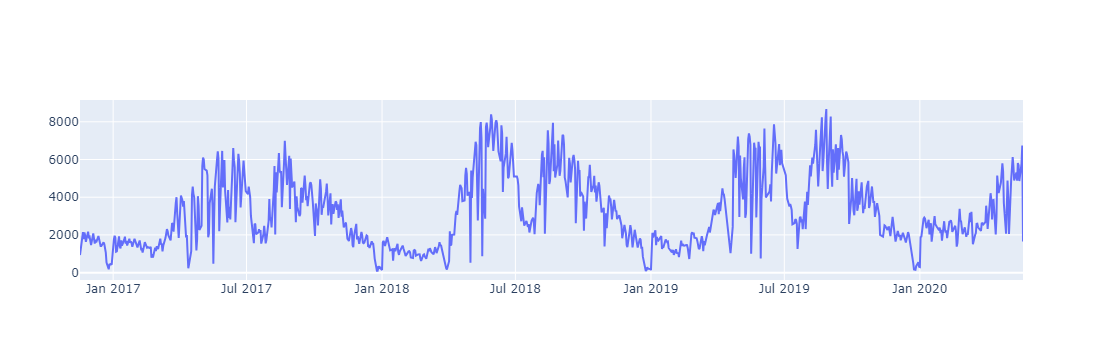

In [53]:
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

### Transformación de Box Cox

In [54]:
# Apply Box-Cox Transform and save the lambda for later inverse.
bikerides['y'], lam = boxcox(bikerides['y'])
print('Lambda is:', lam)

Lambda is: 0.45166936452584744


### Visualización de covariables

In [55]:
bikerides_norm = bikerides[['y', 'rain', 'temp']]

In [56]:
from sklearn.preprocessing import StandardScaler

# create a scaler object
scaler = StandardScaler()
# fit and transform the data
bikerides_norm = pd.DataFrame(scaler.fit_transform(bikerides_norm), columns=bikerides_norm.columns)
bikerides_norm['ds'] = bikerides['ds']

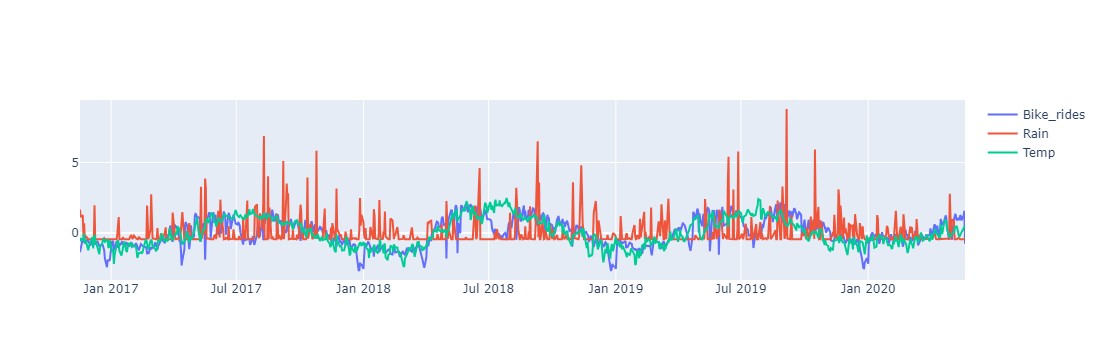

In [57]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['y'], name='Bike_rides',))
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['temp'], name='Temp',))
fig.show()

### Modelo básico de Prophet

In [58]:
np.float = float
np.int = int

# Get hold of the Prophet object
m = Prophet()
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(bikerides)
 
# We must create a data frame holding dates for our forecast. The periods # parameter 
#counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, 
#approximately half a year.
future = m.make_future_dataframe(periods=180, freq='D')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [59]:
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)
# List the predicted values with a lower and upper band.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [60]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1084 2020-11-12  79.228832   63.895415   93.961137
1085 2020-11-13  73.744797   58.342377   89.454554
1086 2020-11-14  60.926019   45.122232   76.574858
1087 2020-11-15  60.311443   44.537428   75.623513
1088 2020-11-16  80.445795   63.996410   94.714890

### Visualización de las predicciones

C:\Users\carlo\AppData\Local\Temp\ipykernel_37688\4229213665.py:5: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



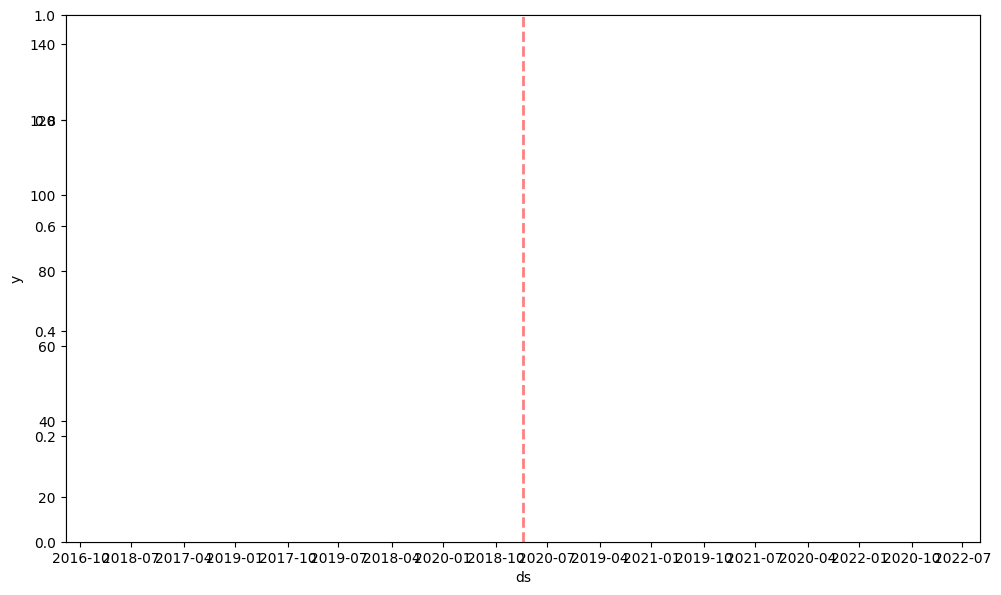

In [61]:
# Plotting with Prophet built-in method
fig = m.plot(forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

### Puntos de cambio

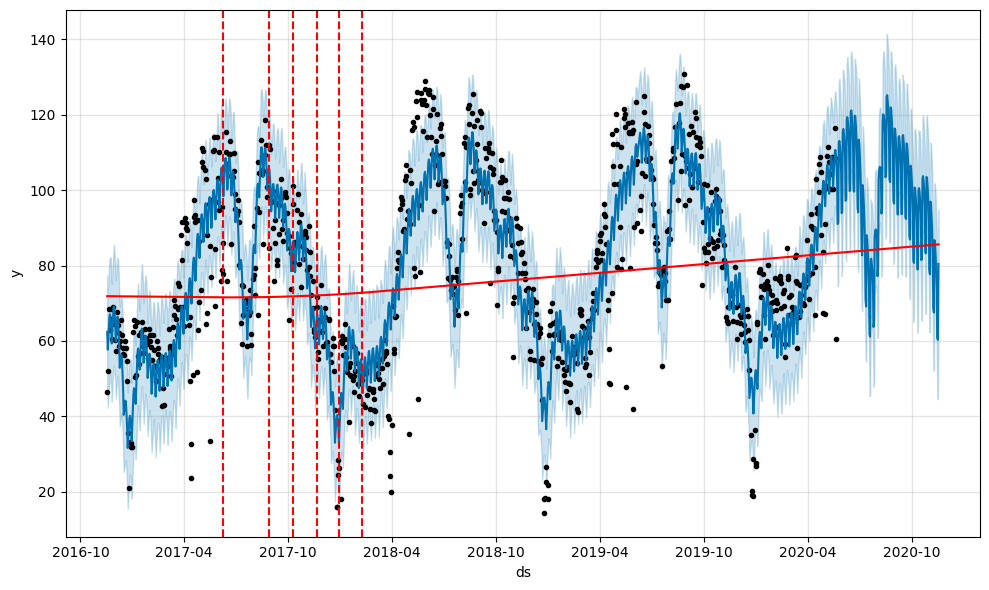

In [62]:

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Todos los puntos de cambio

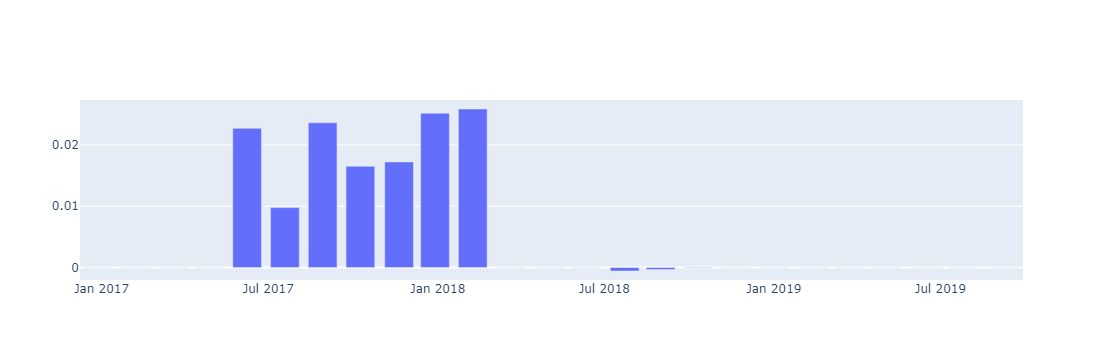

In [63]:
# Listing all the change points in the model
deltas = m.params['delta'].mean(0)
cp = pd.DataFrame(m.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))

### Componentes del modelo

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



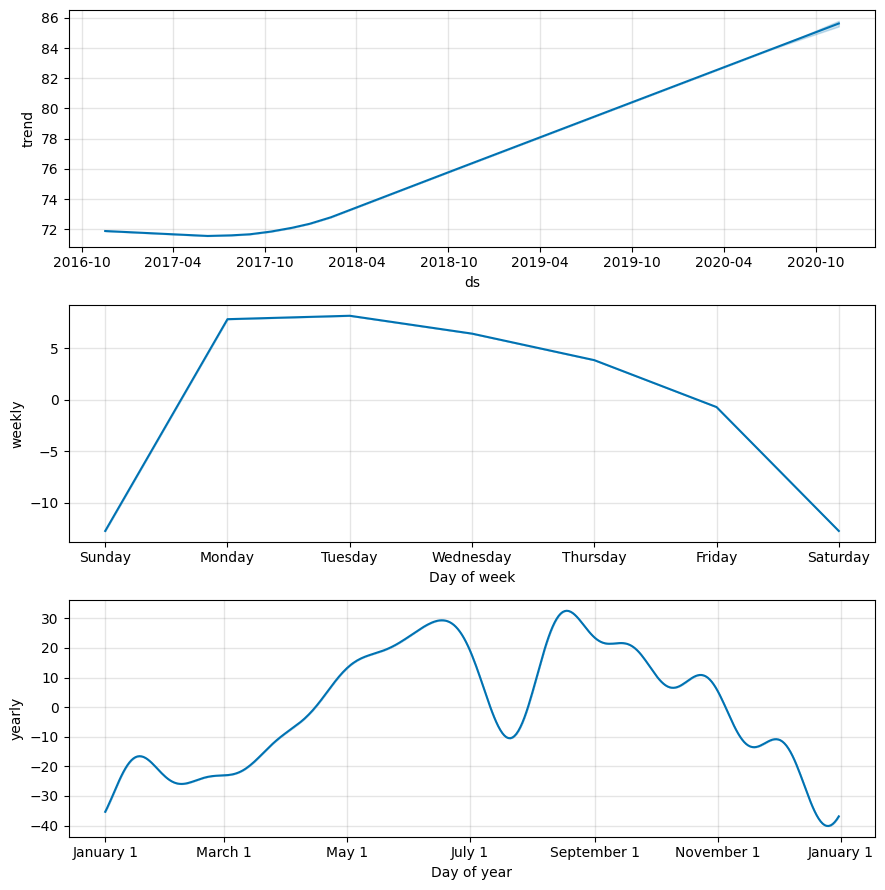

In [64]:
fig = m.plot_components(forecast)

### Validación del modelo

- **Datos de entrenamiento (inicial)**: la cantidad de datos reservados para el entrenamiento.
- **Cutoff (período)** : se hace un pronóstico para cada punto observado entre el corte y el corte + horizonte.
- **Horizonte**: los datos reservados para validación. Si no define un período, el modelo se ajustará a Horizon / 2.

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: Futur

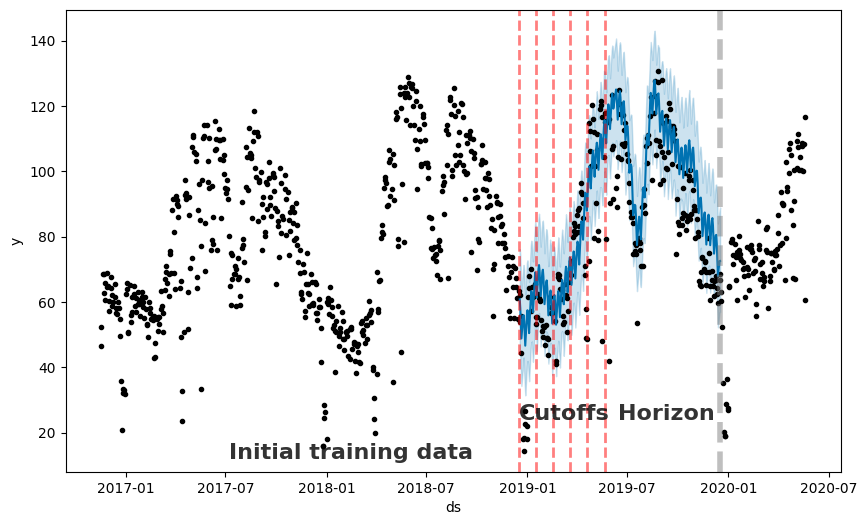

In [65]:
# Fit the model with two years of data and define a horizon of 365 days forcasting per month
df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
#ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs:
    ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2017-07-07'),y=12, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2018-12-17'),y=24, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('180 days'),y=24, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

### Métricas de rendimiento

In [66]:
df_p = performance_metrics(df_cv)
df_p.head(5)

horizon         mse       rmse        mae      mape     mdape  coverage
0 36 days  373.754263  19.332725  14.224234  0.582995  0.124831      0.68
1 37 days  377.229863  19.422406  14.546801  0.588388  0.156643      0.68
2 38 days  377.705088  19.434636  14.595723  0.588844  0.156643      0.68
3 39 days  379.751635  19.487217  14.814994  0.592906  0.156643      0.68
4 42 days  391.875538  19.795846  15.355865  0.602959  0.162621      0.64

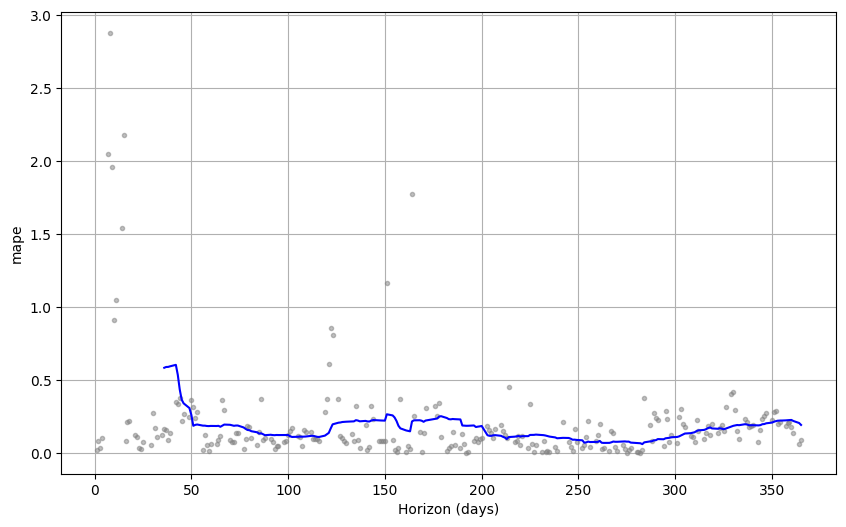

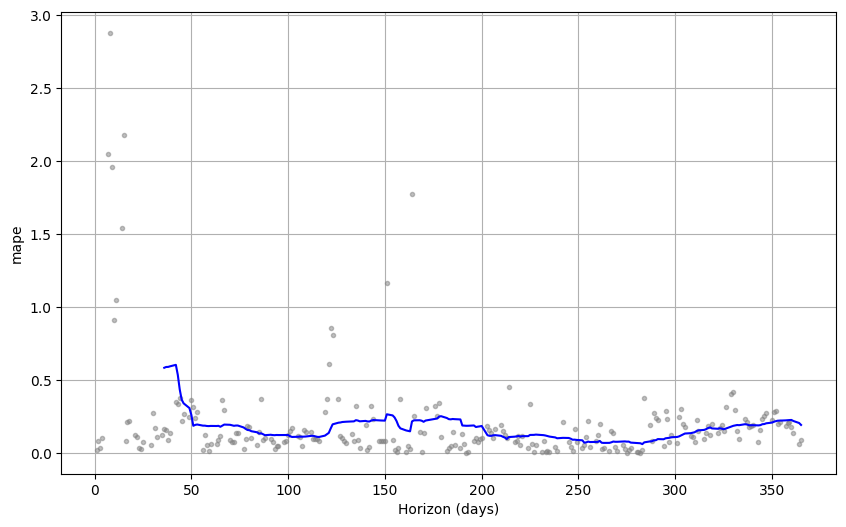

In [67]:
plot_cross_validation_metric(df_cv, metric='mape')

Las métricas de rendimiento de validación cruzada se pueden visualizar con plot_cross_validation_metric, aquí se muestra para MAPE. Los puntos muestran el error porcentual absoluto para cada predicción en df_cv. La línea azul muestra el MAPE, donde la media se toma sobre una ventana móvil de los puntos.

In [68]:
df_p.mean()

horizon     199 days 23:35:10.344827586
mse                          220.006154
rmse                          14.101271
mae                           11.401685
mape                           0.168609
mdape                          0.110061
coverage                       0.747931
dtype: object

In [69]:
def getPerfomanceMetrics(m):
    return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
    return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

### Mejorando el modelo

### Agregando vacaciones

In [70]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



0         Første nyttårsdag
1              Skjærtorsdag
2                Langfredag
3           Første påskedag
4            Andre påskedag
5           Arbeidernes dag
6              Grunnlovsdag
7     Kristi himmelfartsdag
8           Første pinsedag
9            Andre pinsedag
10           Første juledag
11            Andre juledag
dtype: object

In [71]:
forecast = m.predict(future)

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



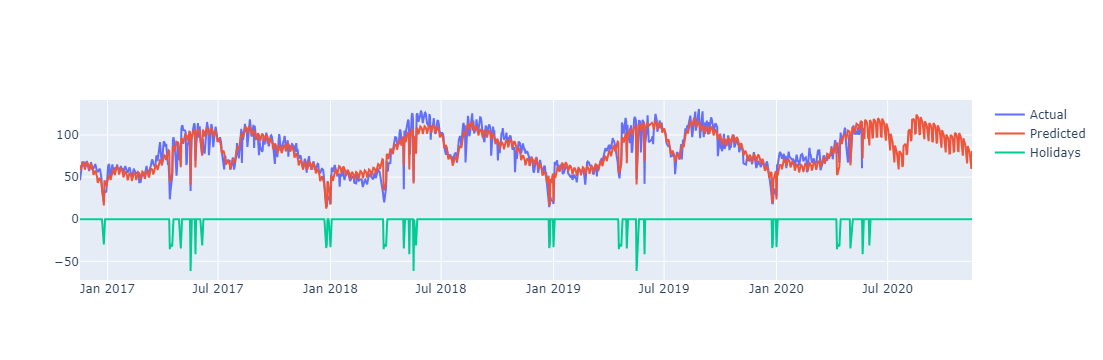

In [72]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

### Añadiendo festivos faltantes

In [73]:
ascensionday = pd.DataFrame({
  'holiday': 'AscensionDay',
  'ds': pd.to_datetime(['2019-05-30']),
  'lower_window': 0,
  'upper_window': 1,
})

christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})

holidays = pd.concat((ascensionday, christmas))

In [74]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



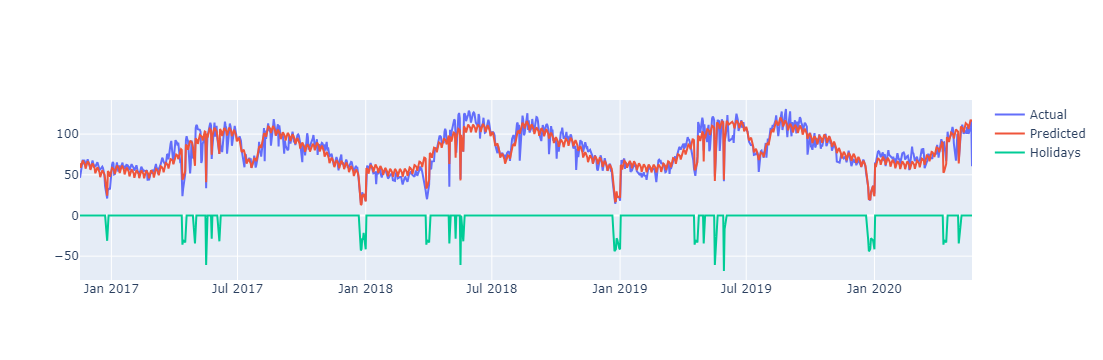

In [75]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

In [76]:
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: Futur

horizon     201 days 00:00:00
mse                124.162239
rmse                11.079768
mae                  8.470684
mape                 0.112738
mdape                0.082897
coverage             0.775617
dtype: object

### Agregando regresores adicionales

In [77]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')

In [78]:
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)
fig = go.Figure()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

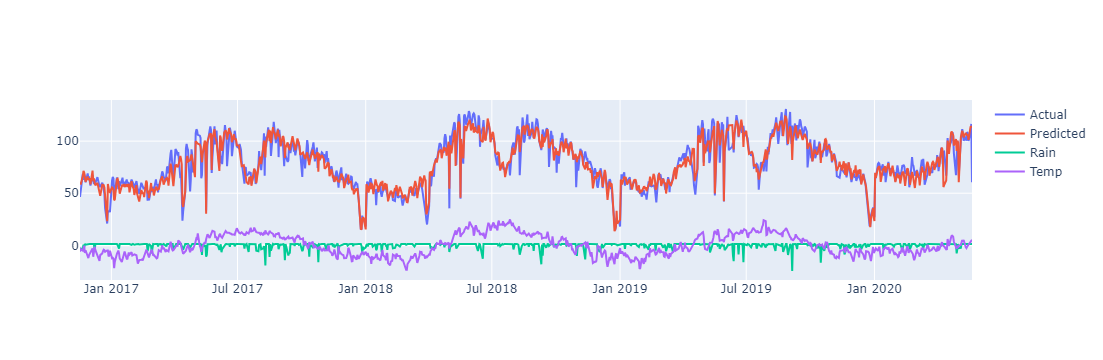

In [79]:
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.show()

In [80]:
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: Futur

horizon     201 days 00:00:00
mse                 90.697367
rmse                 9.490698
mae                  6.875957
mape                 0.092585
mdape                0.061563
coverage             0.797503
dtype: object

### Ajuste de hiperparámetros

In [81]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(holidays=holidays, **param_dict)
    m.add_country_holidays(country_name='NO')
    # Adding the extra weather regressors
    m.add_regressor('rain')
    m.add_regressor('temp')
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [82]:
pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.01],
                'changepoint_range': [0.3],
                'holidays_prior_scale':[1.0],
                'seasonality_prior_scale':[0.5],
                'yearly_seasonality':[20],
                'weekly_seasonality':[5],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

#Prophet(,)
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(bikerides,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
    
results_df = pd.concat(results).reset_index(drop=True)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: Futur

In [83]:
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()


 The best param combination is {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.3, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.5, 'yearly_seasonality': 20.0, 'weekly_seasonality': 5.0}


C:\Users\carlo\AppData\Local\Temp\ipykernel_37688\3883487965.py:3: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



horizon    365 days 00:00:00
rmse                9.364691
mae                 6.926454
mape                 0.09213
mdape               0.068943
dtype: object

#### Probando con los hiperparámetros optimizados

In [84]:
m = Prophet(holidays=holidays, changepoint_prior_scale=0.01,
            changepoint_range=0.3,
            seasonality_prior_scale=0.5,
            holidays_prior_scale=1.0,
            yearly_seasonality=20,
            weekly_seasonality=5,
            seasonality_mode='additive')

m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')

In [85]:
m.fit(bikerides)
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: Futur

horizon     201 days 00:00:00
mse                 85.770037
rmse                 9.232457
mae                  6.907456
mape                 0.089434
mdape                0.068475
coverage             0.785914
dtype: object

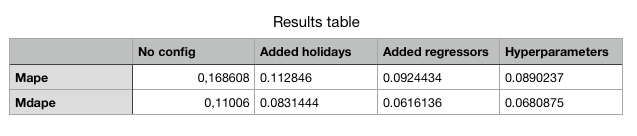

### Trazar y verificar todo el modelo

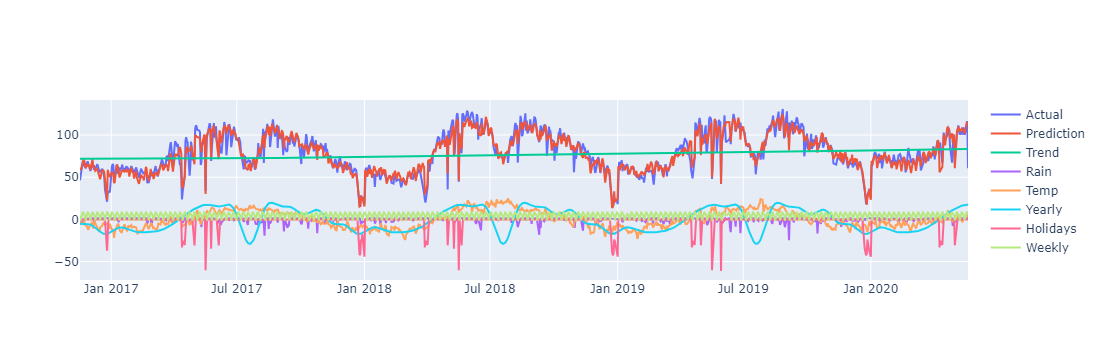

In [86]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], name='Weekly',))
fig.show()

In [87]:
# Let's get the sum of yhat (the prediction)
sum_yhat = forecast['yhat'].sum()
print('Forecast sum is:', sum_yhat)

sum_components = forecast['trend'].sum()+forecast['yearly'].sum()+ forecast['weekly'].sum()+forecast['holidays'].sum()+ forecast['extra_regressors_additive'].sum()
print('Sum of components is:', sum_components)
print('The model is equal to the sum of its components:', sum_yhat.round()==sum_components.round())

Forecast sum is: 71675.61180253667
Sum of components is: 71675.61180253667
The model is equal to the sum of its components: True


### Predicción con datos reales

In [88]:
# Make a zero days forecast just for plotting
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\carlo\anaconda3\envs\neuralprophet\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [89]:
# Transform back to reality from Box Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
bikerides['y'] = inv_boxcox(bikerides['y'], lam)

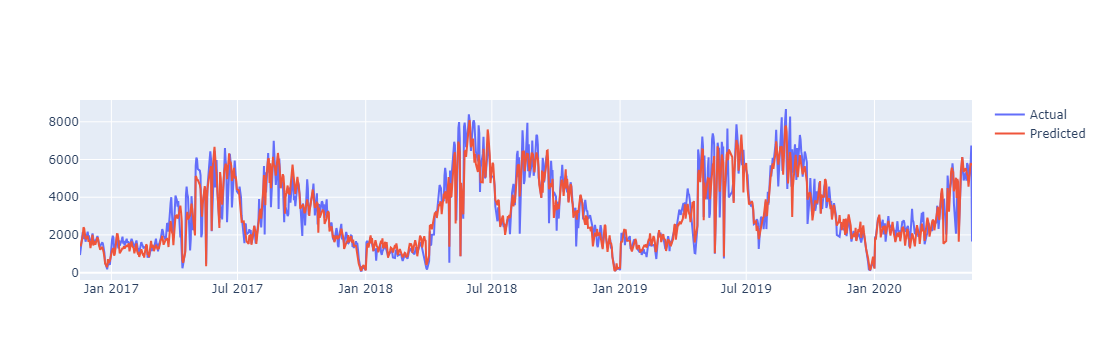

In [90]:
# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.show()